In [1]:
# import libraries
import geopandas
import pandas as pd
import matplotlib
import numpy as np
import sklearn
import mglearn
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import statistics as st
from sklearn import preprocessing
from sklearn.metrics import silhouette_score 
from sklearn.cluster import KMeans 
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import *
from scipy.cluster.hierarchy import linkage, dendrogram
%matplotlib inline 
from Geographycal_functions import assign_color, plot_clustering_results

In [2]:
# upload dataset Donuld Trump
states_scaled = pd.read_csv('States_mineddf_total (3).csv')
print('Dimension of array:{}'.format(states_scaled.shape))

Dimension of array:(51, 36)


## Data preprocessing for the clustering analysis

In [3]:
# Create correlation matrix
corr_matrix = states_scaled.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
states_scaled.drop(to_drop, axis=1, inplace=True)

In [4]:
# Firstly we should drop the columns which are not important for clustering 
# Names of states do not influence the results of clustering
state_names = states_scaled['STATE_NAME']
states_scaled.drop(['STATE_NAME'], axis=1, inplace=True)

Some features are highly correlated, so we can exclude one of them from the analysis.
Both features have almost the same correlation with other features, so it doesn't metter which one to exclude (it should not influence the results of clustering somehow). As 'retweet_count' has worse distribution than 'likes', it was decided to exclude 'retweet_count'.

In [5]:
# rounding to 3 decimal
states_scaled = states_scaled.round(3)

In [6]:
# PCA (principal component analysis)

from sklearn.decomposition import PCA

pca = PCA(n_components=10)
states_scaled_pca = pca.fit_transform(states_scaled)

In [7]:
states_scaled_pca = np.matrix(states_scaled_pca)
states_scaled_pca.shape

(51, 10)

In [8]:
states_scaled_pca = pd.DataFrame(states_scaled_pca)

In [9]:
# Calculate Euclidean distance (distance between dataset)
# This will ensure that the elements are combined into clusters and store them in a special variable

#donald_df
data_dist = pdist (states_scaled, 'euclidean')
data_linkage = linkage (data_dist, method = 'average')

## Determining the number of clusters

### Elbow method

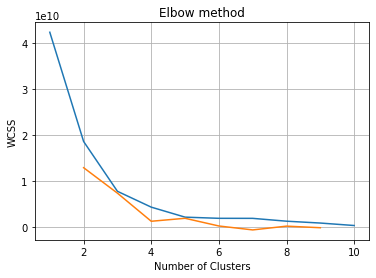

clusters: 2


In [10]:
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

plt.grid()
plt.show()

k = acceleration_rev.argmax()+ 2 
print("clusters:", k)

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


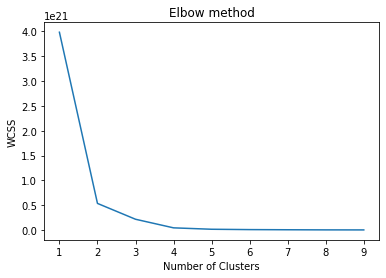

In [11]:
kmeans_models = [KMeans(n_clusters=k, random_state=23).fit(states_scaled) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]

plt.plot(range(1, 10), innertia)
plt.title('Elbow method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

According to Elbow method we should stick to 2 or 3 clusters

### Silhouette coefficient

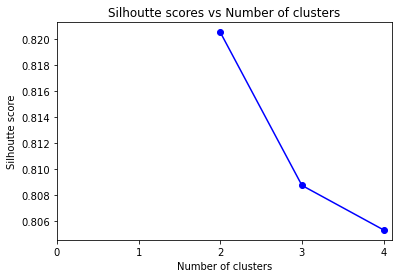

In [12]:
from sklearn.metrics import silhouette_score

silhoutte_scores = [silhouette_score(states_scaled, model.labels_) for model in kmeans_models[5:8]]
plt.plot(range(2,5), silhoutte_scores, "bo-")
plt.xticks([0,1,2,3,4])
plt.title('Silhoutte scores vs Number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoutte score')
plt.show()

In [13]:
# determine the number of clusters using the K-means method
for n_cluster in range (2, 11):
    kmeans = KMeans (n_clusters = n_cluster) .fit (states_scaled)
    label = kmeans.labels_
    sil_coeff = silhouette_score (states_scaled, label, metric = 'euclidean')
    print ("For n_clusters = {}, The Silhouette Coefficient is {}". format (n_cluster, sil_coeff))

For n_clusters = 2, The Silhouette Coefficient is 0.9328288722922022
For n_clusters = 3, The Silhouette Coefficient is 0.8847883589916075
For n_clusters = 4, The Silhouette Coefficient is 0.8676332527454961
For n_clusters = 5, The Silhouette Coefficient is 0.8598875840854682
For n_clusters = 6, The Silhouette Coefficient is 0.8205465099315173
For n_clusters = 7, The Silhouette Coefficient is 0.8087486875223778
For n_clusters = 8, The Silhouette Coefficient is 0.8053197840875124
For n_clusters = 9, The Silhouette Coefficient is 0.7934794831296275
For n_clusters = 10, The Silhouette Coefficient is 0.5774254094202412


According to the Silhouette coefficient we should stick to 2 clusters.

### Hierarchical clustering and dendrogram

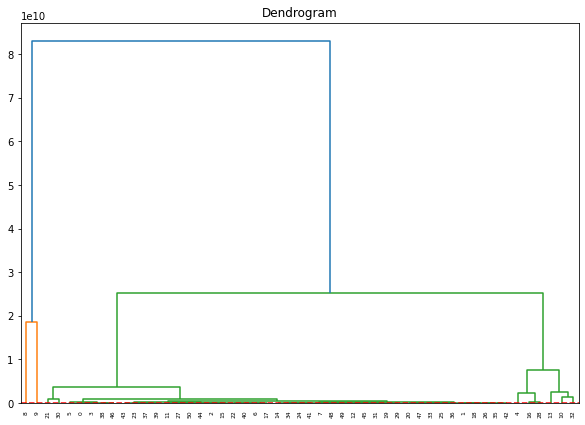

In [14]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(states_scaled, method='ward'))
plt.axhline(y=2, color='r', linestyle='--')

From hierarchical clustering we see that we should devide data into 2 or 4 clusters.

## Clustering 

### Clustering with K-means

In [15]:
# build clustering using the KMeans method
km = KMeans(n_clusters = 3, random_state = 12).fit(states_scaled)

In [16]:
# display the resulting distribution by clusters
# also the number of the cluster to which the string belongs
clustersKmean = km.labels_ + 1
clustersKmean

array([1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 3, 1, 1, 3, 1, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [17]:
len(km.labels_)
states_scaled['id_clusters'] = np.array(km.labels_ +1) 
states_scaled.columns

Index(['likes_Mean', 'user_followers_count_Mean', 'TextBlob_Subjectivity_Mean',
       'TextBlob_Polarity_Mean', 'likes_Skewness',
       'user_followers_count_Skewness', 'TextBlob_Subjectivity_Skewness',
       'TextBlob_Polarity_Skewness', 'likes_Median', 'retweet_count_Median',
       'user_followers_count_Median', 'TextBlob_Polarity_Median',
       'likes_Variance', 'user_followers_count_Variance',
       'TextBlob_Subjectivity_Variance', 'TextBlob_Polarity_Variance',
       'likes_0_1_quant', 'retweet_count_0_1_quant',
       'user_followers_count_0_1_quant', 'TextBlob_Subjectivity_0_1_quant',
       'TextBlob_Polarity_0_1_quant', 'likes_0_9_quant',
       'user_followers_count_0_9_quant', 'TextBlob_Polarity_0_9_quant',
       'id_clusters'],
      dtype='object')

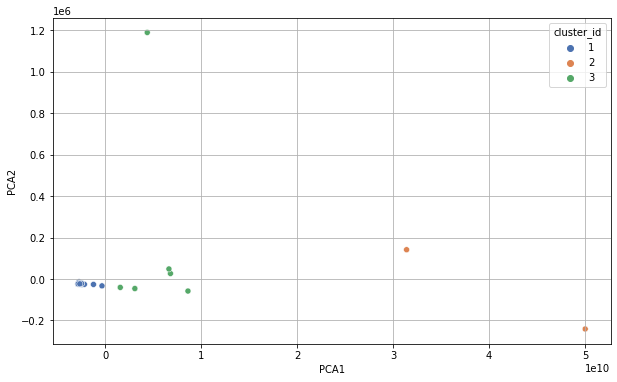

In [18]:
#Lets visialize the clusters
states_scaled['cluster_id'] = km.labels_ + 1 
states_scaled_pca = pd.DataFrame(states_scaled_pca)
states_scaled_pca['cluster_id'] = km.labels_ + 1 
    
plt.figure(figsize=(10,6))
sns.scatterplot(data=states_scaled_pca, x = 0, y = 1, hue ='cluster_id', palette = 'deep')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

plt.grid()
plt.show()

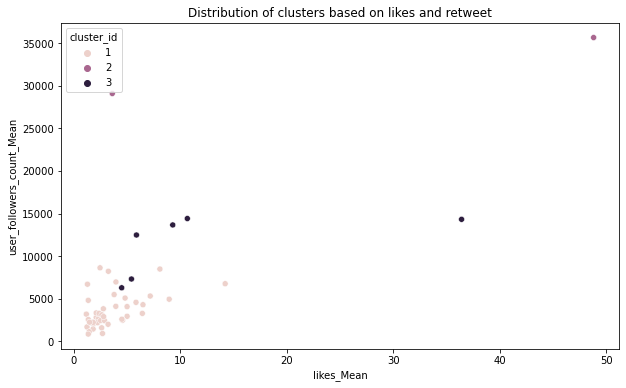

In [19]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=states_scaled, x='likes_Mean', y='user_followers_count_Mean', hue='cluster_id')
plt.title('Distribution of clusters based on likes and retweet')
plt.show()

In [20]:
# add cluster numbers to the original data
dataK = states_scaled
dataK['group_no'] = clustersKmean

# Creating a new file with clusters
writer = pd.ExcelWriter ('states_scaled_for_clust.xlsx')
dataK.to_excel (writer, 'KMeans')
writer.save ()

# For credit PCA
data = states_scaled
data['group_no'] = clustersKmean
writer = pd.ExcelWriter ('states_scaled_for_clust_pca.xlsx')
data.to_excel (writer, 'KMeans')
writer.save ()

In [21]:
states_scaled_for_clust = pd.read_excel('states_scaled_for_clust.xlsx')
credit_dfstates_scaled = print('Dimension of array:{}'.format(states_scaled_for_clust.shape))
states_scaled_for_clust

Dimension of array:(51, 28)


,Unnamed: 0,likes_Mean,user_followers_count_Mean,TextBlob_Subjectivity_Mean,TextBlob_Polarity_Mean,likes_Skewness,user_followers_count_Skewness,TextBlob_Subjectivity_Skewness,TextBlob_Polarity_Skewness,likes_Median,...,retweet_count_0_1_quant,user_followers_count_0_1_quant,TextBlob_Subjectivity_0_1_quant,TextBlob_Polarity_0_1_quant,likes_0_9_quant,user_followers_count_0_9_quant,TextBlob_Polarity_0_9_quant,id_clusters,cluster_id,group_no
0,0,3.968,6975.042,0.336,0.084,15.354,3.666,0.461,0.339,0,...,0,19.0,0,-0.156,6.0,8226.0,0.500,1,1,1
1,1,1.192,3201.983,0.332,0.061,8.201,4.311,0.328,0.583,0,...,0,11.0,0,-0.195,3.0,4188.0,0.417,1,1,1
2,2,5.017,2947.507,0.321,0.069,38.971,22.353,0.517,0.208,0,...,0,27.0,0,-0.200,4.0,5949.0,0.433,1,1,1
3,3,1.372,4821.268,0.325,0.073,8.065,5.192,0.466,0.480,0,...,0,34.3,0,-0.194,3.0,2187.0,0.400,1,1,1
4,4,5.425,7322.299,0.319,0.066,95.096,32.793,0.514,0.298,0,...,0,25.0,0,-0.200,4.0,5792.0,0.438,3,3,3
5,5,2.789,3827.469,0.321,0.052,44.746,18.948,0.510,0.342,0,...,0,31.0,0,-0.199,3.0,4010.6,0.400,1,1,1
6,6,8.966,4954.868,0.297,0.058,11.662,6.054,0.664,0.315,0,...,0,19.0,0,-0.200,5.0,15010.0,0.444,1,1,1
7,7,1.253,1697.679,0.290,0.066,10.146,16.775,0.599,-0.037,0,...,0,10.0,0,-0.150,3.0,3901.0,0.386,1,1,1
8,8,48.795,35643.534,0.296,0.065,27.803,8.292,0.653,0.422,1,...,0,38.0,0,-0.156,18.0,20275.1,0.400,2,2,2
9,9,3.625,29083.497,0.304,0.067,29.623,12.099,0.589,0.470,0,...,0,31.0,0,-0.171,4.0,26451.0,0.425,2,2,2


In [22]:
print(pd.concat([states_scaled['cluster_id'],state_names], axis=1))

    cluster_id            STATE_NAME
0            1               Alabama
1            1                Alaska
2            1               Arizona
3            1              Arkansas
4            3            California
5            1              Colorado
6            1           Connecticut
7            1              Delaware
8            2  District of Columbia
9            2               Florida
10           3               Georgia
11           1                Hawaii
12           1                 Idaho
13           3              Illinois
14           1               Indiana
15           1                  Iowa
16           3                Kansas
17           1              Kentucky
18           1             Louisiana
19           1                 Maine
20           1              Maryland
21           1         Massachusetts
22           1              Michigan
23           1             Minnesota
24           1           Mississippi
25           1              Missouri
2

In [23]:
# add cluster numbers to the original data
dataK = states_scaled
dataK['group_no'] = clustersKmean

In [24]:
# Creating a new file with clusters
writer = pd.ExcelWriter('tweets_scaled_clust.xlsx')
dataK.to_excel(writer, 'KMeans')
writer.save()

In [25]:
# upload the USA map

states_scaled = pd.concat([states_scaled, state_names], axis=1)
usa = geopandas.read_file("Maps/states.shp")
gdf = usa.merge(states_scaled, how="inner", on = 'STATE_NAME')

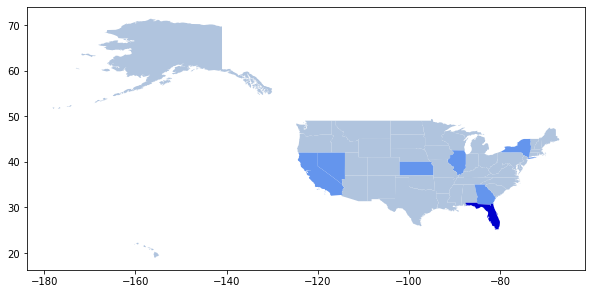

In [26]:
gdf['Color'] = gdf['cluster_id'].apply(assign_color)
plot_clustering_results(gdf)